**descriptive**
- diversity of algorithms
- parameter tuning
- understanding algorithm behavior	
- performance measure	
- correct interpretation of performance measures	
- comparative analysis of results	
- model improvement	
- analysis of results	

**predictive**
- diversity of tasks	
- diversity of algorithms	
- parameter tuning	
- understanding algorithm behavior	
- (performance estimation) training vs test	
- (perfomance estimation): other factors (e.g. time)	
- (performance estimation): perfomance measure	
- (performance estimation): correct interpretation of performance measures	
- (performance estimation): analysis of results	
- model improvement	
- feature importance	
- analysis of "white-box" models	


## Imports and Dataset

In [542]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ml models imports
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve, RocCurveDisplay, accuracy_score, f1_score, make_scorer, plot_confusion_matrix


#import lightgbm as lgb
from IPython.display import Markdown, display

import warnings
warnings.filterwarnings('ignore')


from time import sleep


In [543]:
df = pd.read_csv('../test_ml/main_df.csv')
transactions_df = pd.read_csv('../test_ml/transactions_df.csv')
irrelevant_columns_df = pd.read_csv('../test_ml/irrelevant_columns_df.csv')
amount_outliers_df = pd.read_csv('../test_ml/amount_outliers_df.csv')
age_loan_outliers_df = pd.read_csv('../test_ml/age_loan_outliers_df.csv')


In [544]:
df['frequency'].value_counts()

1    259
0     51
2     18
Name: frequency, dtype: int64

## Metrics

In [545]:
def apply(
    df,
    model_instance,
    parameter_grid,
    cross_validation=StratifiedKFold(n_splits=5),
    feature_selection=False,
    oversample=False
):
    scaler = StandardScaler().fit(X=df)
    X = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)
    y = df['status']

    instance_parameter_grid = {}

    for parameter_name, parameter_values in parameter_grid.items():
        instance_parameter_grid[f"model__{parameter_name}"] = parameter_values

    parameter_grid = instance_parameter_grid

    pipeline = []

    if feature_selection:
        rfe = SelectKBest(f_classif, k=10)
        pipeline.append(('feature_selection', rfe))

    if oversample:
        pipeline.append(('sampling', SMOTE(n_jobs=-1)))

    pipeline.append(("model", model_instance))

    estimator = Pipeline(steps=pipeline)

    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
    scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(
        accuracy_score), "F1": make_scorer(f1_score)}

    grid_search = GridSearchCV(
        estimator,
        param_grid=parameter_grid,
        cv=cross_validation,
        scoring=scoring,
        refit="AUC"
    )


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 101) 
    grid_search.fit(X_train, y_train)
    grid_predictions = grid_search.predict(X_test) 


    display(Markdown(f"### **Classification report:** \n\n {classification_report(y_test, grid_predictions)}"))
    display(Markdown(f"### **Best score:** \n\n {grid_search.best_score_}"))
    display(Markdown(f"### **Best parameters:** \n\n {grid_search.best_params_}"))
    display(Markdown("### **Confusion matrix:** "))
    plot_confusion_matrix(grid_search, X_test, y_test, cmap="PuBuGn")  
    plt.show()
    display(Markdown("### **ROC curve:** "))

    fpr, tpr, thresholds = roc_curve(y_test, grid_predictions)
    roc_auc = auc(fpr, tpr)
    display_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='example estimator')
                                   
    display_roc.plot()
    plt.show()
    display(Markdown("---"))


    return grid_search


## ML Models

##### Decision Tree

In [546]:
"""
interesting parameters to tune:
    - criterion (function used to measure the quality of a split): gini (default), entropy or log_loss
    - splitter (strategy used to choose a split): best (default) or random
    - random_state (controls the randomness of the estimator)
"""




def apply_decision_tree(df):
    parameter_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': range(1, 7)
    }
    return (apply(
        df, 
        tree.DecisionTreeClassifier(),
        parameter_grid, 
        oversample=oversample,
        feature_selection=feature_selection
    ) for oversample, feature_selection in ((False, False), (False, True), (True, False), (True,True)))


##### Logistic Regression

In [547]:
"""
interesting parameters to tune:
    - max_iter (maximum number of iterations taken for the solvers to converge, default 100)
    - solver (algorithm to use in the optimization problem): lbfgs (default)

some notes on the solver:
    - for small datasets, liblinear is a good choice, whereas sag and saga are faster for large ones;
    - for multiclass problems, only newton-cg, sag, saga and lbfgs handle multinomial loss;
    - liblinear is limited to one-versus-rest schemes.
"""



def apply_logistic_regression(df):
    parameter_grid = {
    "max_iter": [1000, 5000, 10000],
    "solver": ["lbfgs", "saga", "sag"]
    }
    return (apply(
        df,
        LogisticRegression(class_weight="balanced"),
        parameter_grid,
        oversample=oversample,
        feature_selection=feature_selection
    ) for oversample, feature_selection in ((False, False), (False, True), (True, False), (True,True)))

##### Naive Bayes 

In [548]:
"""
interesting parameters to tune:
    - 
"""


def apply_naive_bayes(df):
    return (apply(
        df,
        GaussianNB(),
        {},
        oversample=oversample,
        feature_selection=feature_selection
    ) for oversample, feature_selection in ((False, False), (False, True), (True, False), (True,True)))

##### K-Nearest Neighbors

In [549]:
def apply_k_nearest_neighbours(df):
    parameter_grid = {
    'n_neighbors': [4, 5, 6, 7, 10, 15],
    'leaf_size': [5, 10, 15, 20, 50, 100],
    'n_jobs': [-1],
    'algorithm': ['auto']
    }
    return (apply(
        df,
        KNeighborsClassifier(),
        parameter_grid,
        oversample=oversample,
        feature_selection=feature_selection
    ) for oversample, feature_selection in ((False, False), (False, True), (True, False), (True,True)))


##### Random Forest

In [550]:
"""
interesting parameters to tune:
    - n_estimators (number of trees in the forest, default 100)
    - criterion (function used to measure the quality of a split): gini (default), entropy or log_loss
    - max_depth (maximum depth of the tree, default None)
    - n_jobs
"""


def apply_random_forest(df):
    parameter_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [5, 10, 15],
    'n_jobs': [-1],  # Use all cores
    'criterion': ['gini', 'entropy']
    }
    return (apply(
        df,
        RandomForestClassifier(),
        parameter_grid,
        oversample=oversample,
        feature_selection=feature_selection
    ) for oversample, feature_selection in ((False, False), (False, True), (True, False), (True,True)))

##### Gradient Boosting

In [551]:
"""
interesting parameters to tune:
    - 
"""

def apply_gradient_boosting(df):
    parameter_grid = {
    'loss': ['log_loss', 'deviance', 'exponential'],
    'criterion': ['friedman_mse', 'squared_error', 'mse'],
    }
    return (apply(
        df,
        GradientBoostingClassifier(),
        parameter_grid,
        oversample=oversample,
        feature_selection=feature_selection
    ) for oversample, feature_selection in ((False, False), (False, True), (True, False), (True,True)))

##### SVC

In [552]:
def apply_svc(df):
    parameter_grid = {
    'C': [1, 10, 50],
    'gamma': [0.001, 0.0001],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }
    return (apply(
        df,
        SVC(),
        parameter_grid,
        oversample=oversample,
        feature_selection=feature_selection
    ) for oversample, feature_selection in ((False, False), (False, True), (True, False), (True,True)))

Comparing Models

In [553]:
import seaborn as sb

def compare_models(dt, lr, nb, knn, rf, gb, svc):
    scores = {
        "Decision Tree": dt,
        "Logistic Regression": lr,
        "Naive Bayes": nb,
        "K-nearest Neighbours": knn,
        "Random Forest": rf,
        "Gradient Boosting": gb,
        "SVC": svc,
    }

    x_axis_labels = ["No Feature selection/No oversampling",
                    "Feature Selection", "Oversampling", "Feature Selection/Oversampling"]
    y_axis_labels = scores.keys()

    plt.figure(figsize=(10, 8))

    scores_array = np.array([[model.best_score_ for model in models]
                            for models in scores.values()])

    sb.set(font_scale=1.3)
    sb.heatmap(scores_array, annot=True, linewidths=0.5, vmax=1,
            square=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cbar=False)
    plt.title("ROC-AUC")

    plt.xticks(rotation=45, horizontalalignment='right')
    plt.show()

# **original dataframe** 

### **Classification report:** 

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        87

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {'model__criterion': 'gini', 'model__max_depth': 1, 'model__splitter': 'best'}

### **Confusion matrix:** 

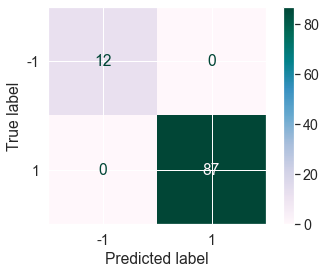

### **ROC curve:** 

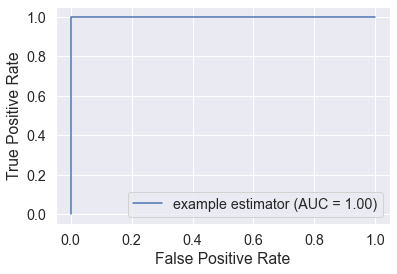

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.38      0.25      0.30        12
           1       0.90      0.94      0.92        87

    accuracy                           0.86        99
   macro avg       0.64      0.60      0.61        99
weighted avg       0.84      0.86      0.85        99


### **Best score:** 

 0.7566544566544566

### **Best parameters:** 

 {'model__criterion': 'entropy', 'model__max_depth': 3, 'model__splitter': 'best'}

### **Confusion matrix:** 

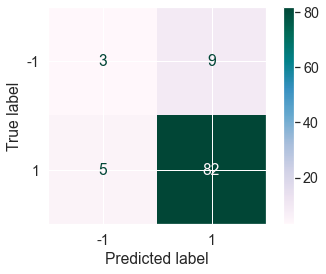

### **ROC curve:** 

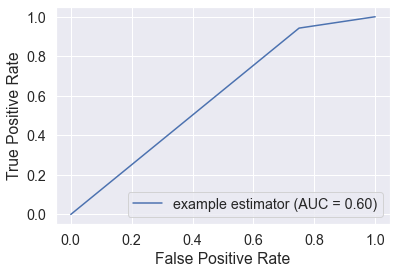

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        87

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {'model__criterion': 'gini', 'model__max_depth': 1, 'model__splitter': 'best'}

### **Confusion matrix:** 

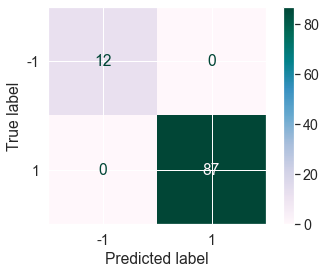

### **ROC curve:** 

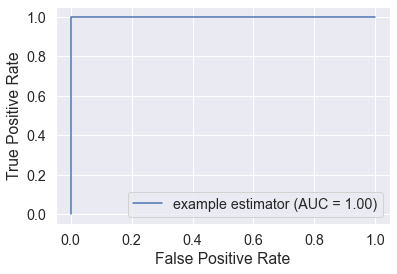

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.15      0.67      0.25        12
           1       0.91      0.48      0.63        87

    accuracy                           0.51        99
   macro avg       0.53      0.57      0.44        99
weighted avg       0.82      0.51      0.58        99


### **Best score:** 

 0.7617826617826617

### **Best parameters:** 

 {'model__criterion': 'log_loss', 'model__max_depth': 3, 'model__splitter': 'best'}

### **Confusion matrix:** 

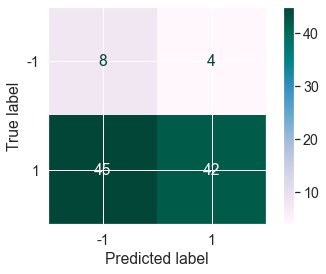

### **ROC curve:** 

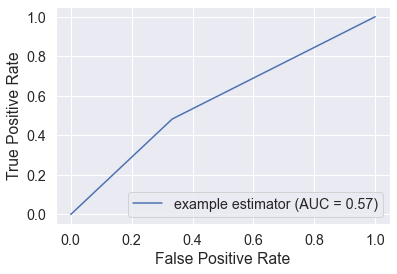

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        87

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {'model__criterion': 'friedman_mse', 'model__loss': 'log_loss'}

### **Confusion matrix:** 

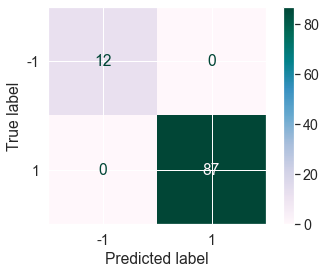

### **ROC curve:** 

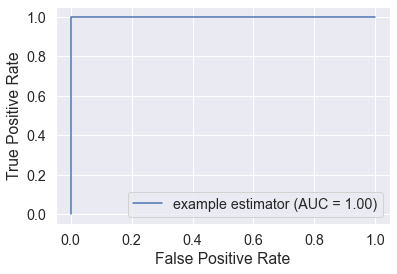

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.33      0.17      0.22        12
           1       0.89      0.95      0.92        87

    accuracy                           0.86        99
   macro avg       0.61      0.56      0.57        99
weighted avg       0.82      0.86      0.84        99


### **Best score:** 

 0.672893772893773

### **Best parameters:** 

 {'model__criterion': 'mse', 'model__loss': 'deviance'}

### **Confusion matrix:** 

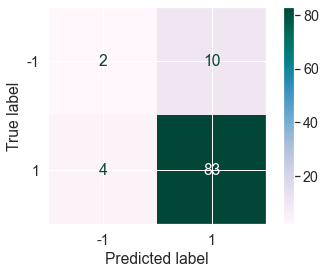

### **ROC curve:** 

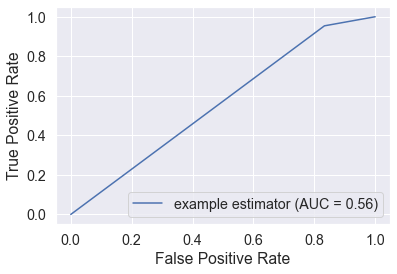

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        87

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {'model__criterion': 'friedman_mse', 'model__loss': 'log_loss'}

### **Confusion matrix:** 

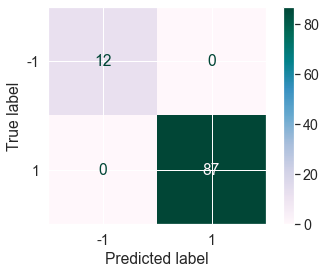

### **ROC curve:** 

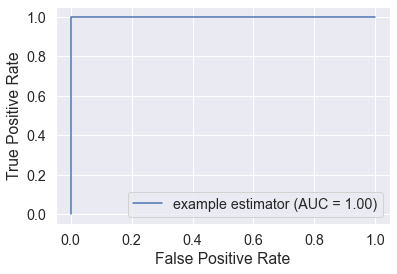

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.16      0.25      0.19        12
           1       0.89      0.82      0.85        87

    accuracy                           0.75        99
   macro avg       0.52      0.53      0.52        99
weighted avg       0.80      0.75      0.77        99


### **Best score:** 

 0.7124542124542125

### **Best parameters:** 

 {'model__criterion': 'friedman_mse', 'model__loss': 'exponential'}

### **Confusion matrix:** 

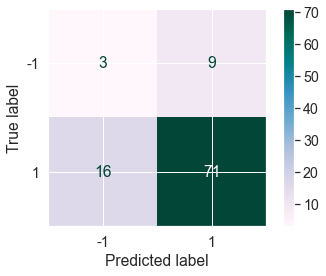

### **ROC curve:** 

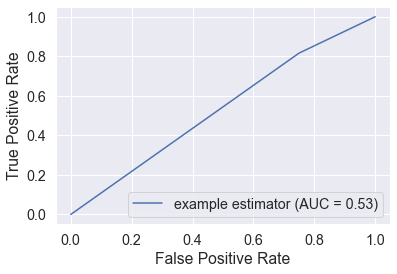

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.89      0.67      0.76        12
           1       0.96      0.99      0.97        87

    accuracy                           0.95        99
   macro avg       0.92      0.83      0.87        99
weighted avg       0.95      0.95      0.95        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {'model__algorithm': 'auto', 'model__leaf_size': 5, 'model__n_jobs': -1, 'model__n_neighbors': 4}

### **Confusion matrix:** 

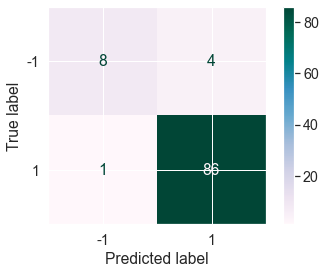

### **ROC curve:** 

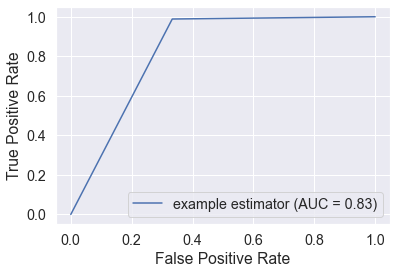

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.00      0.00      0.00        12
           1       0.88      0.99      0.93        87

    accuracy                           0.87        99
   macro avg       0.44      0.49      0.46        99
weighted avg       0.77      0.87      0.82        99


### **Best score:** 

 0.7095848595848595

### **Best parameters:** 

 {'model__algorithm': 'auto', 'model__leaf_size': 5, 'model__n_jobs': -1, 'model__n_neighbors': 15}

### **Confusion matrix:** 

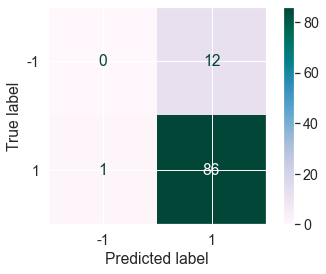

### **ROC curve:** 

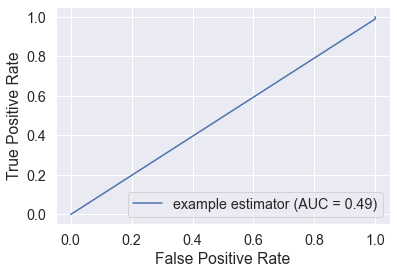

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.85      0.92      0.88        12
           1       0.99      0.98      0.98        87

    accuracy                           0.97        99
   macro avg       0.92      0.95      0.93        99
weighted avg       0.97      0.97      0.97        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {'model__algorithm': 'auto', 'model__leaf_size': 5, 'model__n_jobs': -1, 'model__n_neighbors': 5}

### **Confusion matrix:** 

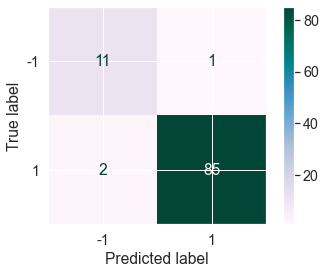

### **ROC curve:** 

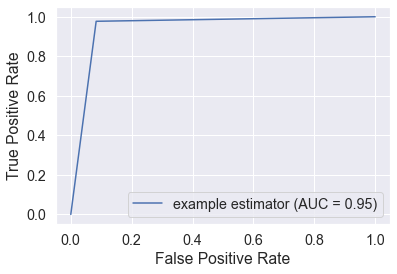

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.15      0.50      0.23        12
           1       0.90      0.61      0.73        87

    accuracy                           0.60        99
   macro avg       0.52      0.55      0.48        99
weighted avg       0.81      0.60      0.67        99


### **Best score:** 

 0.749023199023199

### **Best parameters:** 

 {'model__algorithm': 'auto', 'model__leaf_size': 50, 'model__n_jobs': -1, 'model__n_neighbors': 7}

### **Confusion matrix:** 

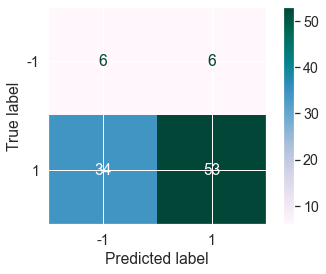

### **ROC curve:** 

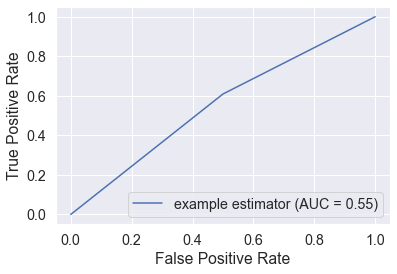

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        87

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {'model__max_iter': 1000, 'model__solver': 'lbfgs'}

### **Confusion matrix:** 

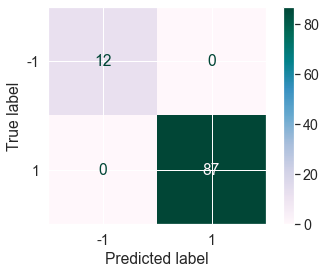

### **ROC curve:** 

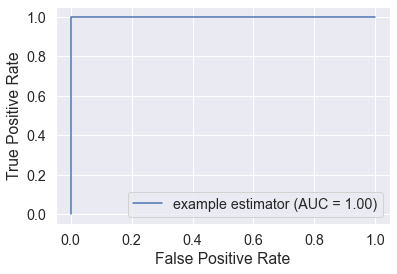

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.19      0.75      0.30        12
           1       0.94      0.55      0.70        87

    accuracy                           0.58        99
   macro avg       0.56      0.65      0.50        99
weighted avg       0.85      0.58      0.65        99


### **Best score:** 

 0.6986568986568986

### **Best parameters:** 

 {'model__max_iter': 1000, 'model__solver': 'lbfgs'}

### **Confusion matrix:** 

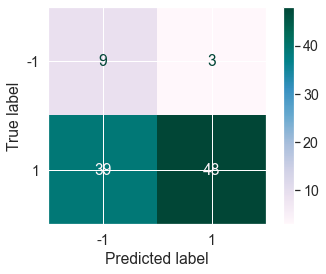

### **ROC curve:** 

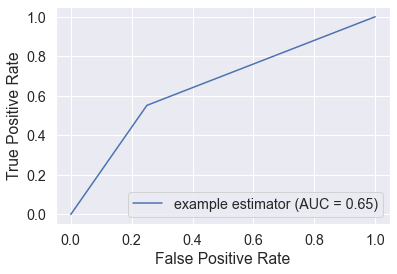

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        87

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {'model__max_iter': 1000, 'model__solver': 'lbfgs'}

### **Confusion matrix:** 

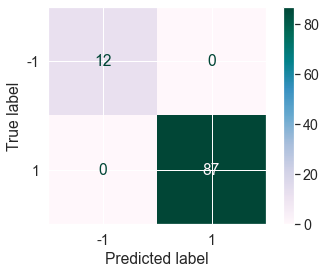

### **ROC curve:** 

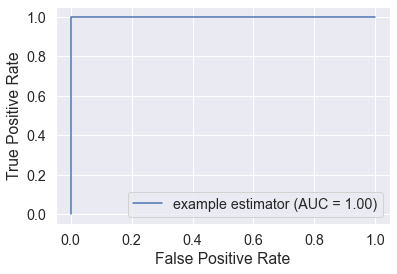

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.19      0.75      0.30        12
           1       0.94      0.55      0.70        87

    accuracy                           0.58        99
   macro avg       0.56      0.65      0.50        99
weighted avg       0.85      0.58      0.65        99


### **Best score:** 

 0.6936507936507936

### **Best parameters:** 

 {'model__max_iter': 10000, 'model__solver': 'sag'}

### **Confusion matrix:** 

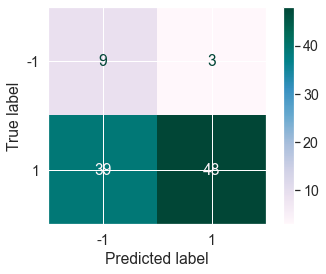

### **ROC curve:** 

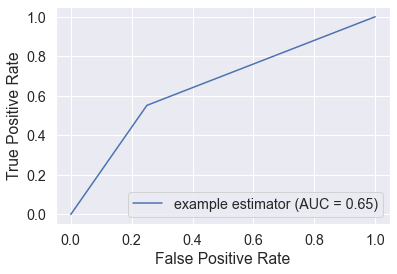

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        87

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {}

### **Confusion matrix:** 

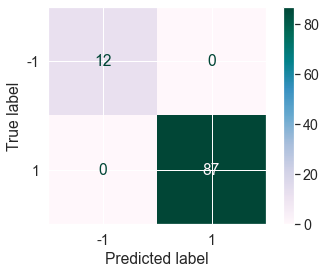

### **ROC curve:** 

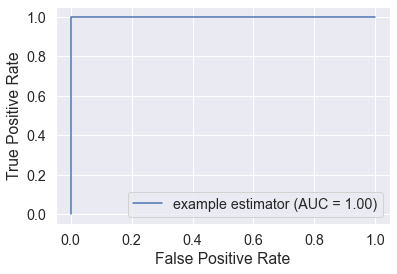

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.14      0.92      0.24        12
           1       0.95      0.23      0.37        87

    accuracy                           0.31        99
   macro avg       0.55      0.57      0.31        99
weighted avg       0.85      0.31      0.36        99


### **Best score:** 

 0.6879120879120879

### **Best parameters:** 

 {}

### **Confusion matrix:** 

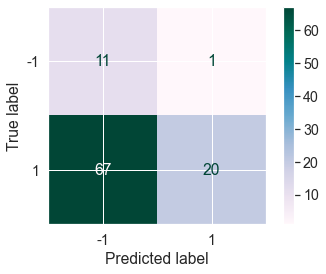

### **ROC curve:** 

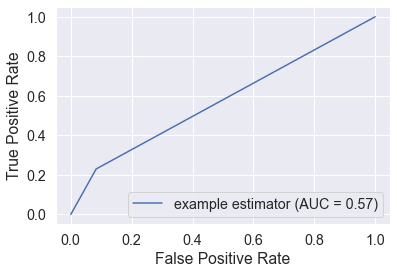

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        87

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {}

### **Confusion matrix:** 

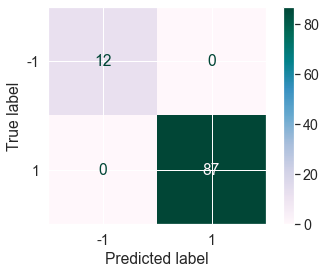

### **ROC curve:** 

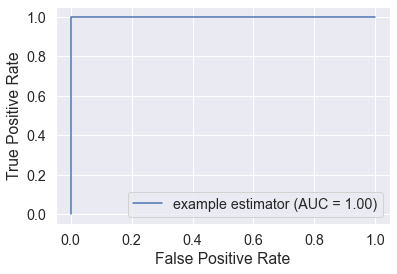

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.14      0.92      0.25        12
           1       0.95      0.24      0.39        87

    accuracy                           0.32        99
   macro avg       0.55      0.58      0.32        99
weighted avg       0.86      0.32      0.37        99


### **Best score:** 

 0.6964590964590964

### **Best parameters:** 

 {}

### **Confusion matrix:** 

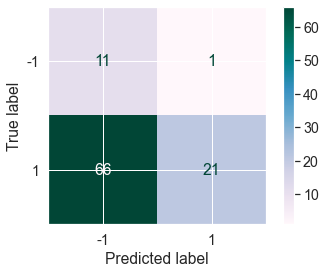

### **ROC curve:** 

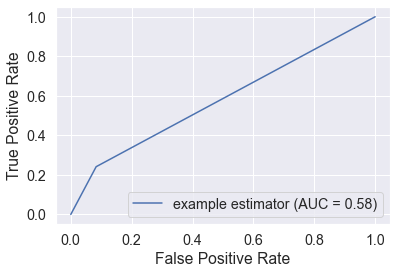

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        87

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {'model__C': 1, 'model__gamma': 0.001, 'model__kernel': 'linear'}

### **Confusion matrix:** 

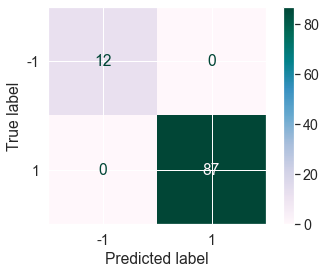

### **ROC curve:** 

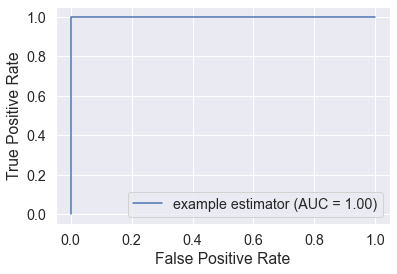

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.00      0.00      0.00        12
           1       0.88      1.00      0.94        87

    accuracy                           0.88        99
   macro avg       0.44      0.50      0.47        99
weighted avg       0.77      0.88      0.82        99


### **Best score:** 

 0.6688644688644689

### **Best parameters:** 

 {'model__C': 50, 'model__gamma': 0.001, 'model__kernel': 'rbf'}

### **Confusion matrix:** 

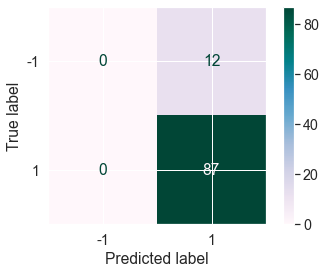

### **ROC curve:** 

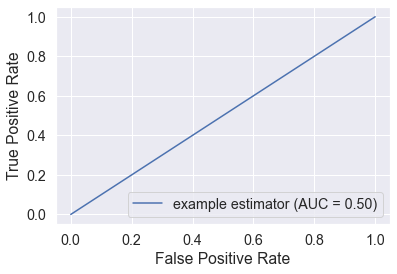

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        87

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {'model__C': 1, 'model__gamma': 0.001, 'model__kernel': 'linear'}

### **Confusion matrix:** 

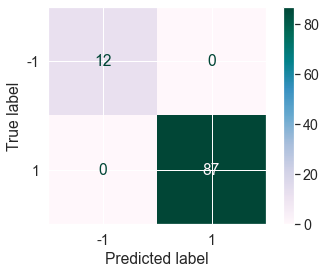

### **ROC curve:** 

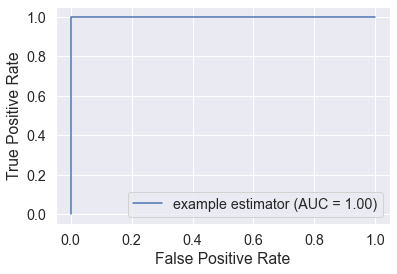

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.18      0.67      0.28        12
           1       0.93      0.57      0.71        87

    accuracy                           0.59        99
   macro avg       0.55      0.62      0.49        99
weighted avg       0.84      0.59      0.66        99


### **Best score:** 

 0.680952380952381

### **Best parameters:** 

 {'model__C': 1, 'model__gamma': 0.001, 'model__kernel': 'linear'}

### **Confusion matrix:** 

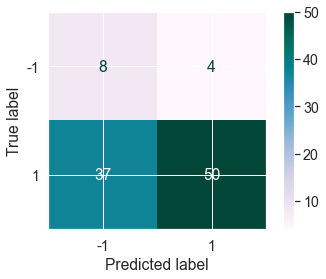

### **ROC curve:** 

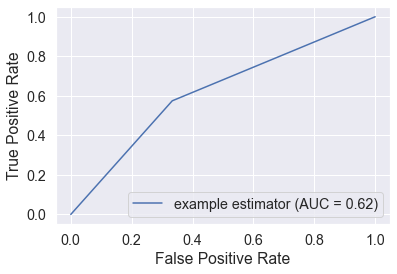

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        87

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {'model__criterion': 'gini', 'model__max_depth': 5, 'model__n_estimators': 10, 'model__n_jobs': -1}

### **Confusion matrix:** 

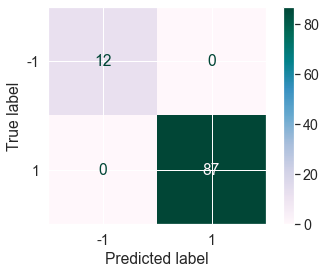

### **ROC curve:** 

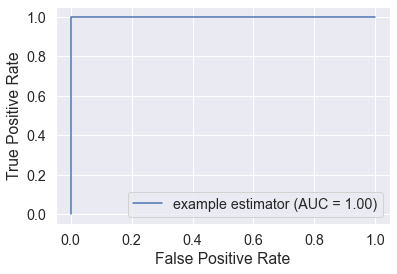

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       1.00      0.08      0.15        12
           1       0.89      1.00      0.94        87

    accuracy                           0.89        99
   macro avg       0.94      0.54      0.55        99
weighted avg       0.90      0.89      0.85        99


### **Best score:** 

 0.7142857142857143

### **Best parameters:** 

 {'model__criterion': 'entropy', 'model__max_depth': 5, 'model__n_estimators': 50, 'model__n_jobs': -1}

### **Confusion matrix:** 

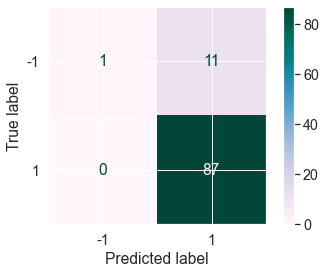

### **ROC curve:** 

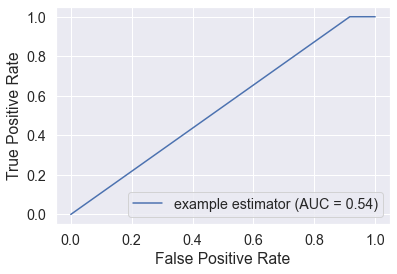

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        87

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {'model__criterion': 'gini', 'model__max_depth': 5, 'model__n_estimators': 10, 'model__n_jobs': -1}

### **Confusion matrix:** 

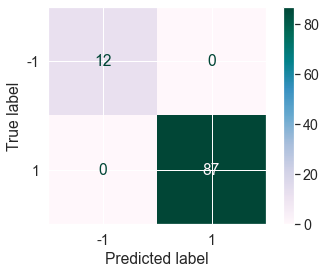

### **ROC curve:** 

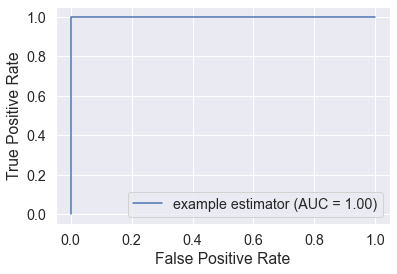

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.18      0.25      0.21        12
           1       0.89      0.84      0.86        87

    accuracy                           0.77        99
   macro avg       0.53      0.54      0.54        99
weighted avg       0.80      0.77      0.78        99


### **Best score:** 

 0.7457875457875457

### **Best parameters:** 

 {'model__criterion': 'gini', 'model__max_depth': 10, 'model__n_estimators': 100, 'model__n_jobs': -1}

### **Confusion matrix:** 

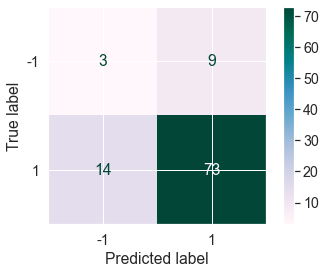

### **ROC curve:** 

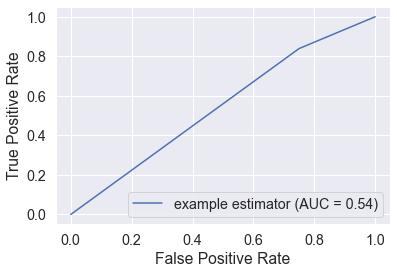

---

### **Compare models** 

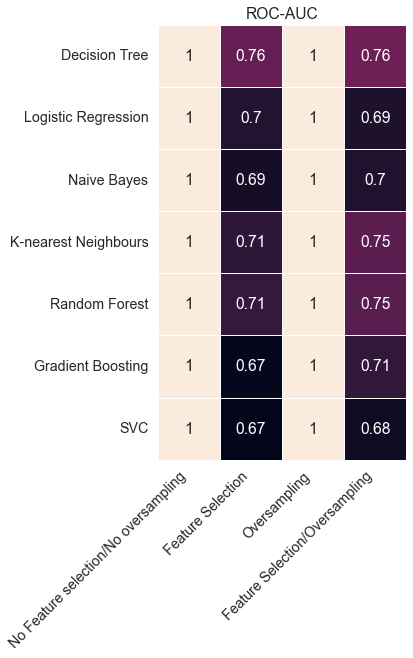

# **irrelevant columns removed dataframe** 

### **Classification report:** 

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        87

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {'model__criterion': 'gini', 'model__max_depth': 1, 'model__splitter': 'best'}

### **Confusion matrix:** 

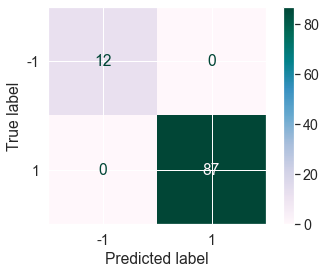

### **ROC curve:** 

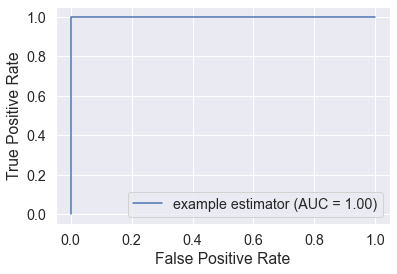

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.38      0.25      0.30        12
           1       0.90      0.94      0.92        87

    accuracy                           0.86        99
   macro avg       0.64      0.60      0.61        99
weighted avg       0.84      0.86      0.85        99


### **Best score:** 

 0.7566544566544566

### **Best parameters:** 

 {'model__criterion': 'entropy', 'model__max_depth': 3, 'model__splitter': 'best'}

### **Confusion matrix:** 

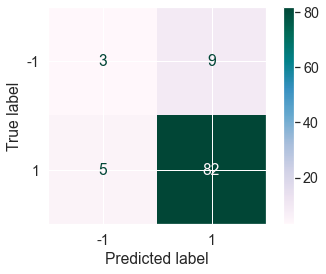

### **ROC curve:** 

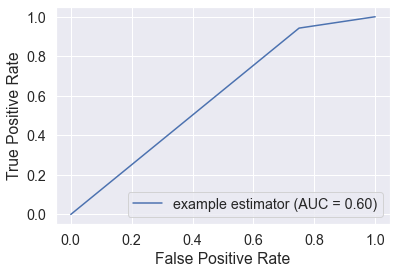

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        87

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {'model__criterion': 'gini', 'model__max_depth': 1, 'model__splitter': 'best'}

### **Confusion matrix:** 

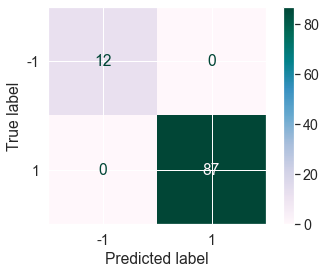

### **ROC curve:** 

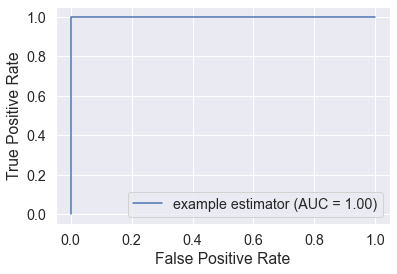

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.14      0.75      0.24        12
           1       0.91      0.37      0.52        87

    accuracy                           0.41        99
   macro avg       0.53      0.56      0.38        99
weighted avg       0.82      0.41      0.49        99


### **Best score:** 

 0.7525641025641026

### **Best parameters:** 

 {'model__criterion': 'gini', 'model__max_depth': 4, 'model__splitter': 'random'}

### **Confusion matrix:** 

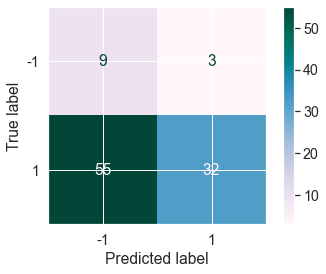

### **ROC curve:** 

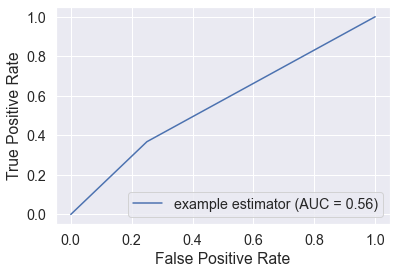

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        87

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {'model__criterion': 'friedman_mse', 'model__loss': 'log_loss'}

### **Confusion matrix:** 

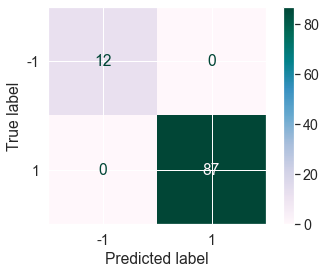

### **ROC curve:** 

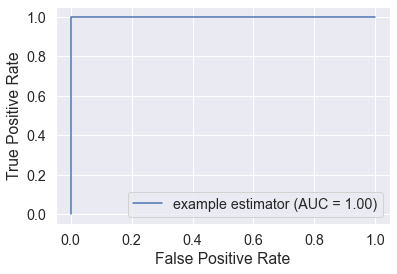

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.50      0.17      0.25        12
           1       0.89      0.98      0.93        87

    accuracy                           0.88        99
   macro avg       0.70      0.57      0.59        99
weighted avg       0.85      0.88      0.85        99


### **Best score:** 

 0.6768009768009768

### **Best parameters:** 

 {'model__criterion': 'mse', 'model__loss': 'exponential'}

### **Confusion matrix:** 

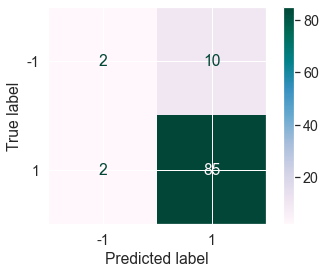

### **ROC curve:** 

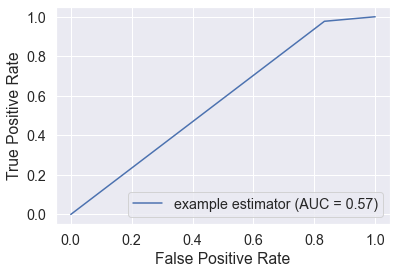

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        87

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {'model__criterion': 'friedman_mse', 'model__loss': 'log_loss'}

### **Confusion matrix:** 

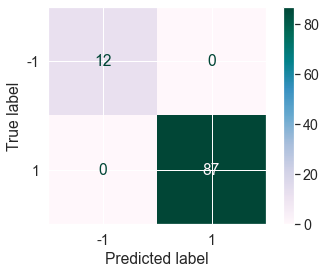

### **ROC curve:** 

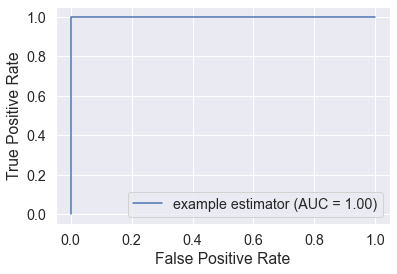

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.10      0.17      0.12        12
           1       0.87      0.79      0.83        87

    accuracy                           0.72        99
   macro avg       0.49      0.48      0.48        99
weighted avg       0.78      0.72      0.75        99


### **Best score:** 

 0.7234432234432234

### **Best parameters:** 

 {'model__criterion': 'mse', 'model__loss': 'exponential'}

### **Confusion matrix:** 

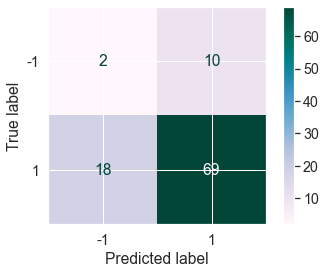

### **ROC curve:** 

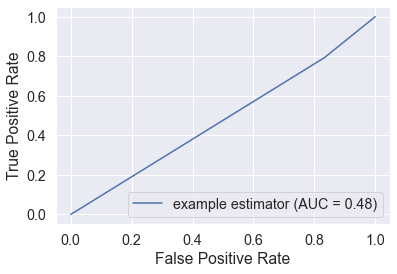

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       1.00      0.67      0.80        12
           1       0.96      1.00      0.98        87

    accuracy                           0.96        99
   macro avg       0.98      0.83      0.89        99
weighted avg       0.96      0.96      0.96        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {'model__algorithm': 'auto', 'model__leaf_size': 5, 'model__n_jobs': -1, 'model__n_neighbors': 4}

### **Confusion matrix:** 

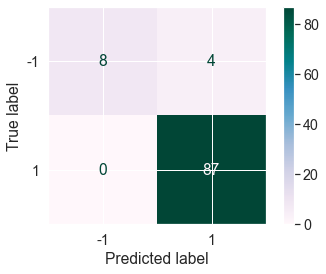

### **ROC curve:** 

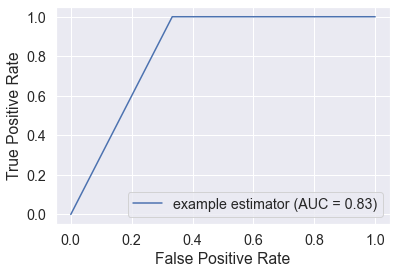

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.00      0.00      0.00        12
           1       0.88      0.99      0.93        87

    accuracy                           0.87        99
   macro avg       0.44      0.49      0.46        99
weighted avg       0.77      0.87      0.82        99


### **Best score:** 

 0.7149572649572649

### **Best parameters:** 

 {'model__algorithm': 'auto', 'model__leaf_size': 5, 'model__n_jobs': -1, 'model__n_neighbors': 15}

### **Confusion matrix:** 

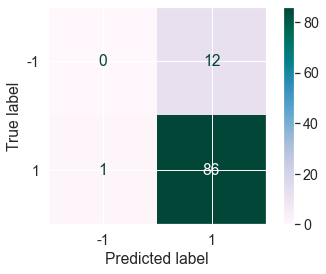

### **ROC curve:** 

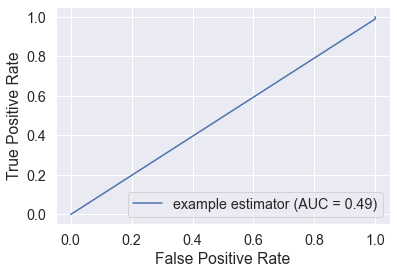

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.83      0.83      0.83        12
           1       0.98      0.98      0.98        87

    accuracy                           0.96        99
   macro avg       0.91      0.91      0.91        99
weighted avg       0.96      0.96      0.96        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {'model__algorithm': 'auto', 'model__leaf_size': 5, 'model__n_jobs': -1, 'model__n_neighbors': 4}

### **Confusion matrix:** 

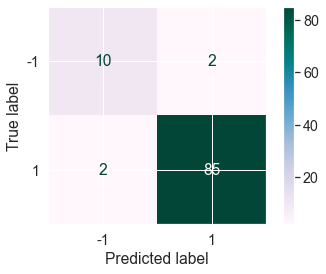

### **ROC curve:** 

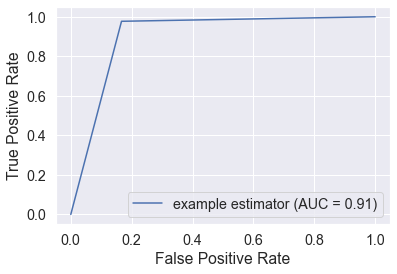

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.11      0.33      0.16        12
           1       0.87      0.62      0.72        87

    accuracy                           0.59        99
   macro avg       0.49      0.48      0.44        99
weighted avg       0.78      0.59      0.66        99


### **Best score:** 

 0.7392551892551893

### **Best parameters:** 

 {'model__algorithm': 'auto', 'model__leaf_size': 10, 'model__n_jobs': -1, 'model__n_neighbors': 5}

### **Confusion matrix:** 

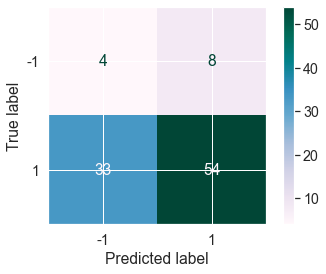

### **ROC curve:** 

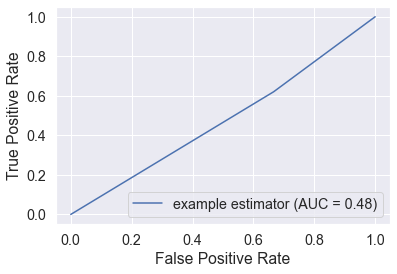

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        87

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {'model__max_iter': 1000, 'model__solver': 'lbfgs'}

### **Confusion matrix:** 

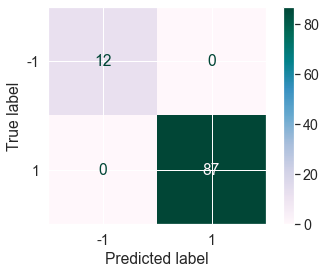

### **ROC curve:** 

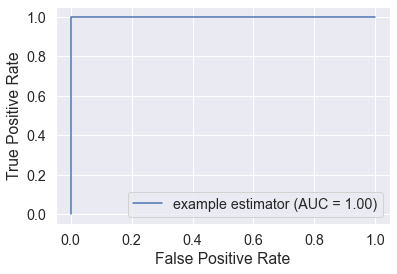

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.19      0.75      0.30        12
           1       0.94      0.55      0.70        87

    accuracy                           0.58        99
   macro avg       0.56      0.65      0.50        99
weighted avg       0.85      0.58      0.65        99


### **Best score:** 

 0.7042735042735042

### **Best parameters:** 

 {'model__max_iter': 1000, 'model__solver': 'lbfgs'}

### **Confusion matrix:** 

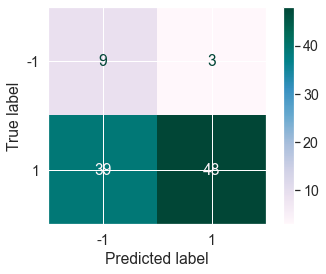

### **ROC curve:** 

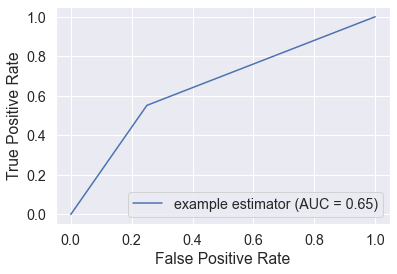

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        87

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {'model__max_iter': 1000, 'model__solver': 'lbfgs'}

### **Confusion matrix:** 

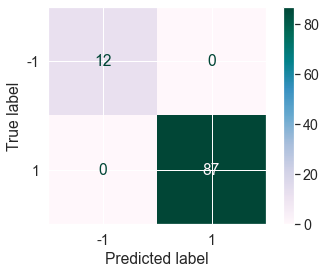

### **ROC curve:** 

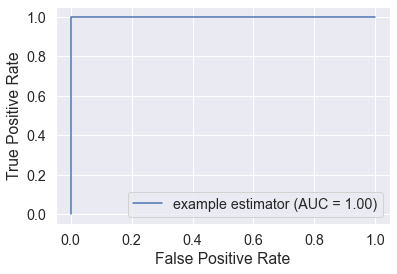

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.20      0.75      0.32        12
           1       0.94      0.59      0.72        87

    accuracy                           0.61        99
   macro avg       0.57      0.67      0.52        99
weighted avg       0.85      0.61      0.67        99


### **Best score:** 

 0.7091575091575091

### **Best parameters:** 

 {'model__max_iter': 5000, 'model__solver': 'saga'}

### **Confusion matrix:** 

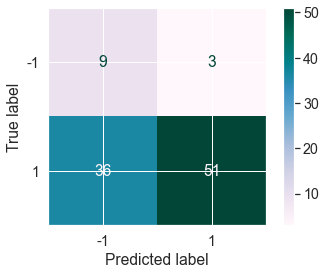

### **ROC curve:** 

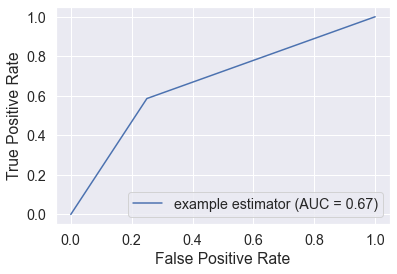

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        87

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {}

### **Confusion matrix:** 

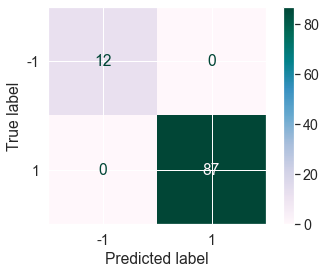

### **ROC curve:** 

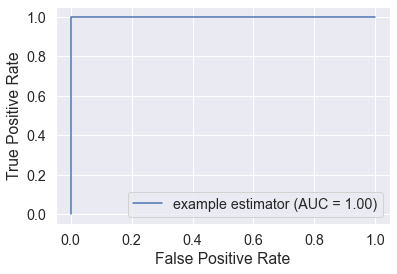

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.14      0.92      0.24        12
           1       0.95      0.23      0.37        87

    accuracy                           0.31        99
   macro avg       0.55      0.57      0.31        99
weighted avg       0.85      0.31      0.36        99


### **Best score:** 

 0.6995115995115996

### **Best parameters:** 

 {}

### **Confusion matrix:** 

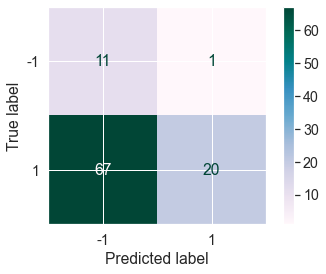

### **ROC curve:** 

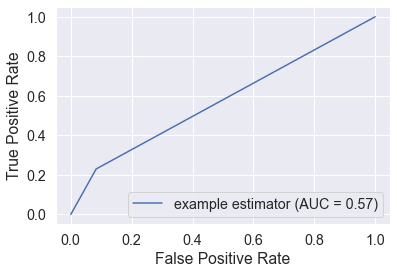

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        87

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {}

### **Confusion matrix:** 

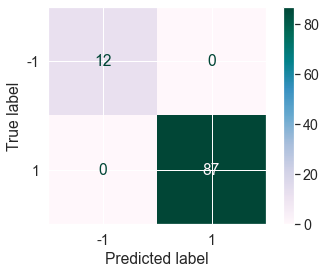

### **ROC curve:** 

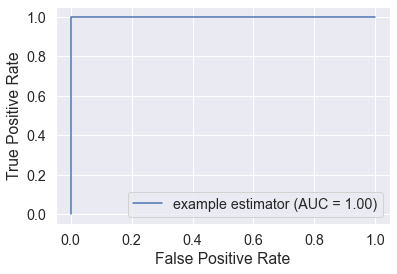

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.14      0.92      0.25        12
           1       0.95      0.24      0.39        87

    accuracy                           0.32        99
   macro avg       0.55      0.58      0.32        99
weighted avg       0.86      0.32      0.37        99


### **Best score:** 

 0.701098901098901

### **Best parameters:** 

 {}

### **Confusion matrix:** 

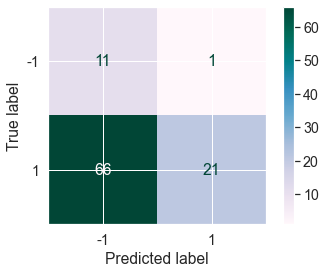

### **ROC curve:** 

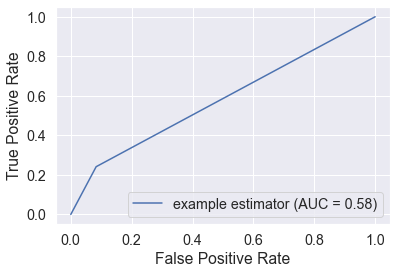

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        87

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {'model__C': 1, 'model__gamma': 0.001, 'model__kernel': 'linear'}

### **Confusion matrix:** 

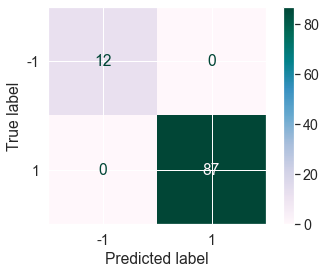

### **ROC curve:** 

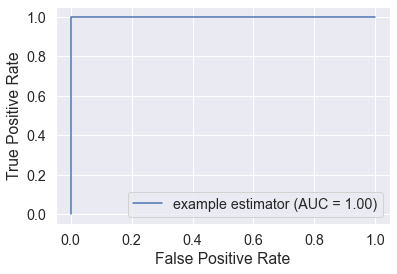

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.00      0.00      0.00        12
           1       0.88      1.00      0.94        87

    accuracy                           0.88        99
   macro avg       0.44      0.50      0.47        99
weighted avg       0.77      0.88      0.82        99


### **Best score:** 

 0.7169719169719169

### **Best parameters:** 

 {'model__C': 50, 'model__gamma': 0.001, 'model__kernel': 'rbf'}

### **Confusion matrix:** 

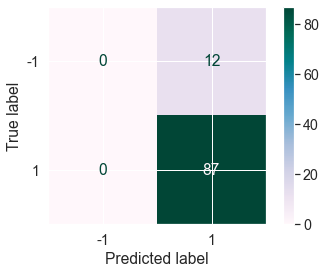

### **ROC curve:** 

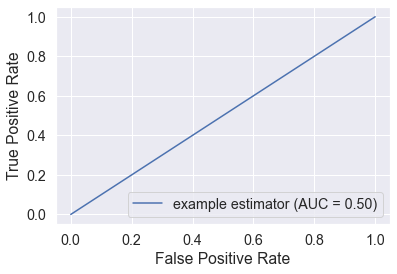

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        87

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {'model__C': 1, 'model__gamma': 0.001, 'model__kernel': 'linear'}

### **Confusion matrix:** 

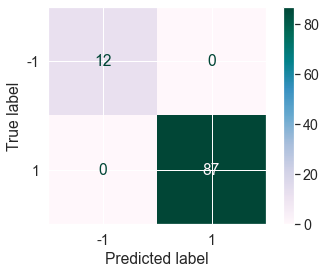

### **ROC curve:** 

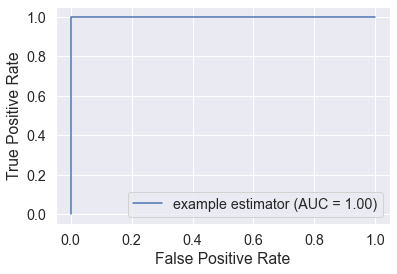

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.20      0.75      0.32        12
           1       0.94      0.59      0.72        87

    accuracy                           0.61        99
   macro avg       0.57      0.67      0.52        99
weighted avg       0.85      0.61      0.67        99


### **Best score:** 

 0.6919413919413919

### **Best parameters:** 

 {'model__C': 50, 'model__gamma': 0.001, 'model__kernel': 'linear'}

### **Confusion matrix:** 

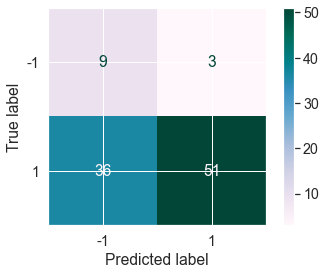

### **ROC curve:** 

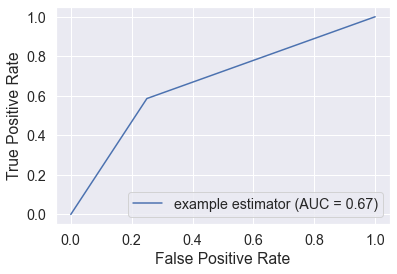

---

### **Classification report:** 

               precision    recall  f1-score   support

          -1       1.00      0.67      0.80        12
           1       0.96      1.00      0.98        87

    accuracy                           0.96        99
   macro avg       0.98      0.83      0.89        99
weighted avg       0.96      0.96      0.96        99


### **Best score:** 

 1.0

### **Best parameters:** 

 {'model__criterion': 'gini', 'model__max_depth': 5, 'model__n_estimators': 10, 'model__n_jobs': -1}

### **Confusion matrix:** 

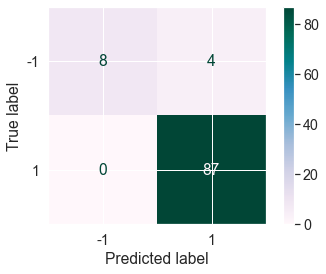

### **ROC curve:** 

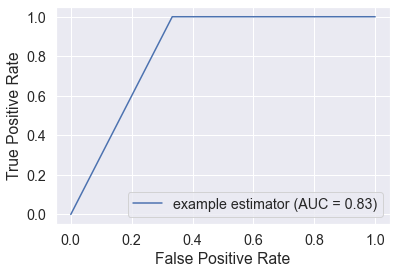

---

KeyboardInterrupt: 

In [554]:
dfs = {
  'original': df, 
  'irrelevant columns removed': irrelevant_columns_df, 
  'amount outliers removed': amount_outliers_df, 
  'age outliers removed': age_loan_outliers_df
  }



for key, value in dfs.items():
  display(Markdown(f"# **{key} dataframe** "))
  dt, dt_fs, dt_os, dt_fs_os = apply_decision_tree(value)
  gb, gb_fs, gb_os, gb_fs_os = apply_gradient_boosting(value)
  knn, knn_fs, knn_os, knn_fs_os = apply_k_nearest_neighbours(value)
  lr, lr_fs, lr_os, lr_fs_os = apply_logistic_regression(value)
  nb, nb_fs, nb_os, nb_fs_os = apply_naive_bayes(value)
  svc, svc_fs, svc_os, svc_fs_os = apply_svc(value)
  rf, rf_fs, rf_os, rf_fs_os = apply_random_forest(value)

  display(Markdown(f"### **Compare models** "))
  compare_models(dt=[dt, dt_fs, dt_os, dt_fs_os], gb=[gb, gb_fs, gb_os, gb_fs_os], knn=[knn, knn_fs, knn_os, knn_fs_os], lr=[lr, lr_fs, lr_os, lr_fs_os], nb=[nb, nb_fs, nb_os, nb_fs_os], svc=[svc, svc_fs, svc_os, svc_fs_os], rf=[rf, rf_fs, rf_os, rf_fs_os])
  sleep(6)
